# Baseline Kinematic Windows — Curation Notebook

This notebook helps you **visualize** and **curate** peri-event kinematic windows saved in a `.npz` file produced by your baseline concatenation script.

**How to use**  
1. Set `NPZ_PATH` to your `.npz` file.  
2. Run the cells in order.  
3. Use the helper functions:
   - `plot_event(idx, traces=None)` — plot a single window (event).  
   - `plot_gallery(indices, ncols=4, traces=None, sharey=False)` — small multiples to scan events.  
   - `plot_mean_sem(indices=None, traces=None)` — mean ± SEM across selected events (or all).  
   - `save_curation(keep_indices, note="...")` — write a `*_CURATED.json` next to the `.npz`.

> Tip: `traces` can be a list of column indices to show (e.g., `traces=[0,1,2,3]`).  
> Columns correspond to the flattened keypoint coordinates order used during export (e.g., `wrist_x, wrist_y, fingerbase_x, fingerbase_y, ...`).  


In [ ]:
# Imports and configuration
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

# matplotlib inline settings (optional)
%matplotlib inline

NOTEBOOK_PATH = Path.cwd()
BASE = NOTEBOOK_PATH.parents[2]
NPZ_PATH = (BASE / "Nike" / "NRR_RW003" / "results" / "checkpoints" /
            "behavior" / "baseline_concat" / "baseline_UA_B_Depth43_cam0_curated.npz").resolve()

print(NPZ_PATH)
print("exists:", NPZ_PATH.exists())
assert NPZ_PATH.exists(), f'NPZ file not found: {NPZ_PATH}'

/home/bryan/mnt/cullen/Current Project Databases - NHP/2025 Cerebellum prosthesis/Nike/NRR_RW003/results/checkpoints/behavior/baseline_concat/baseline_UA_B_Depth43_cam0_curated.npz
exists: True


In [10]:
# Load
data = np.load(NPZ_PATH, allow_pickle=True)
print('Keys in NPZ:', data.files)

# Expected keys: windows (N,K,T), t_ms (T,), labels (K,), events_sec (N,), trials (N,)
windows = data['windows']              # shape: (N, K, T)
t_ms    = data['t_ms']                 # shape: (T,)
labels  = data.get('labels', None)     # optional
events_sec = data.get('events_sec', None)  # optional
trials  = data.get('trials', None)         # optional

N, K, T = windows.shape
print(f'windows shape: {windows.shape}  (events x traces x time)')
print(f't_ms shape:     {t_ms.shape} (ms), span: {t_ms[0]:.1f} → {t_ms[-1]:.1f} ms')
print('labels:', labels if labels is not None else '(none)')
print('events_sec available:', events_sec is not None)
print('trials available:', trials is not None)


Keys in NPZ: ['windows', 't_ms', 'labels', 'events_sec', 'trials', 'anchor_ms', 'ua_port', 'depth_mm']
windows shape: (58, 6, 151)  (events x traces x time)
t_ms shape:     (151,) (ms), span: -750.0 → 750.0 ms
labels: ['cam0_DLC_Resnet50_Nike_09_29_TrainingSep29shuffle1_snapshot_100_wrist_x'
 'cam0_DLC_Resnet50_Nike_09_29_TrainingSep29shuffle1_snapshot_100_wrist_y'
 'cam0_DLC_Resnet50_Nike_09_29_TrainingSep29shuffle1_snapshot_100_middle_finger_base_x'
 'cam0_DLC_Resnet50_Nike_09_29_TrainingSep29shuffle1_snapshot_100_middle_finger_base_y'
 'cam0_DLC_Resnet50_Nike_09_29_TrainingSep29shuffle1_snapshot_100_middle_finger_tip_x'
 'cam0_DLC_Resnet50_Nike_09_29_TrainingSep29shuffle1_snapshot_100_middle_finger_tip_y']
events_sec available: True
trials available: True


In [14]:
# Helper functions for visualization & curation

from typing import Iterable, Optional, List, Sequence

def list_traces(max_show: int = 50):
    """Print up to first `max_show` labels (or indices if labels missing)."""
    if labels is None:
        print('No labels present. Use numeric column indices [0..K-1].')
        return
    for i, name in enumerate(labels):
        if i >= max_show:
            print(f'... ({K - max_show} more)')
            break
        print(f'{i:3d}: {name}')

def _default_traces(traces: Optional[Iterable[int]] = None) -> List[int]:
    if traces is None:
        # by default: show first 4 columns if they exist
        return list(range(min(4, K)))
    return list(traces)

def _fmt_evt_s(i: int) -> str:
    try:
        s = float(events_sec[i])
        if np.isfinite(s):
            return f"{s:.3f}s"
    except Exception:
        pass
    return "t=?s"

def plot_event(idx: int, traces: Optional[Iterable[int]] = None, title: Optional[str] = None):
    """Plot a single event window for selected trace columns."""
    assert 0 <= idx < N, f'idx out of range (0..{N-1})'
    trs = _default_traces(traces)
    plt.figure(figsize=(10, 4))
    offset = 0.0
    offs = []
    for j in trs:
        y = windows[idx, j, :]
        p5, p95 = np.nanpercentile(y, [5, 95]) if np.isfinite(y).any() else (0, 1)
        span = max(p95 - p5, 1e-6)
        if len(offs) == 0:
            offset = 0.0
        else:
            offset += 1.2 * span
        offs.append(offset)
        plt.plot(t_ms, y + offset, lw=1.0, label=(labels[j] if labels is not None else f'trace{j}'))
    plt.axvline(0.0, ls='--', lw=0.8, color='k')
    plt.yticks([])
    plt.xlabel('Time (ms)')

    evt_txt = _fmt_evt_s(idx)
    auto_title = f'Event {idx} @ {evt_txt} (IR)'
    plt.title(title or auto_title)
    plt.legend(loc='upper right', fontsize=8, frameon=False)
    plt.tight_layout()
    plt.show()

def plot_gallery(
    indices: Iterable[int],
    ncols: int = 4,
    traces: Optional[Iterable[int]] = None,
    sharey: bool = False,
    trace_names: Optional[Sequence[str]] = None,
):
    """Plot small multiples of many events for fast scanning.
    Shows a single legend (one entry per trace) based on the first panel's colors.
    """
    idxs = list(indices)
    trs = _default_traces(traces)
    if not idxs:
        print('No indices provided.')
        return

    # Build legend labels for the selected traces
    def _name_for(j: int) -> str:
        if trace_names is not None and j < len(trace_names) and trace_names[j]:
            return str(trace_names[j])
        try:
            return str(labels[j])  # falls back to a global `labels` if present
        except Exception:
            return f"trace_{j}"

    legend_labels = [_name_for(j) for j in trs]

    n = len(idxs)
    ncols = max(1, int(ncols))
    nrows = (n + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows), squeeze=False, sharey=sharey)
    axes = axes.ravel()

    legend_handles = None  # to capture first panel's line objects

    for ax_i, (ax, idx) in enumerate(zip(axes, idxs)):
        if idx < 0 or idx >= N:
            ax.set_axis_off()
            continue
        offset = 0.0
        panel_lines = []
        for k, j in enumerate(trs):
            y = windows[idx, j, :]
            if np.isfinite(y).any():
                p5, p95 = np.nanpercentile(y, [5, 95])
            else:
                p5, p95 = (0.0, 1.0)
            span = max(p95 - p5, 1e-6)

            # Only label on the first valid panel so colors map to legend entries
            if ax_i == 0:
                ln, = ax.plot(t_ms, y + offset, lw=0.9, label=legend_labels[k])
                panel_lines.append(ln)
            else:
                ax.plot(t_ms, y + offset, lw=0.9)

            offset += 1.2 * span

        if ax_i == 0 and panel_lines:
            legend_handles = panel_lines  # store for a single, global legend

        ax.axvline(0.0, ls='--', lw=0.8, color='k')
        ax.set_title(f'#{idx}  @ {_fmt_evt_s(idx)}', fontsize=9)
        ax.set_yticks([])

    # hide any extra axes
    for k in range(len(idxs), len(axes)):
        axes[k].set_axis_off()

    # Single, global legend (uses first panel's line colors)
    if legend_handles:
        # Put legend outside top-right; adjust layout to make room
        fig.legend(legend_handles, legend_labels, loc='upper right', bbox_to_anchor=(0.99, 0.99),
                   frameon=False, fontsize=9)

        # Leave a bit of top margin so legend doesn't overlap title
        fig.tight_layout(rect=[0, 0, 0.98, 0.95])
    else:
        fig.tight_layout()

    fig.suptitle('Event Gallery (IR times in seconds)', y=0.995, fontsize=12)
    plt.show()

There are 58 events and 6 trace columns.
First few labels (if present):
  0: cam0_DLC_Resnet50_Nike_09_29_TrainingSep29shuffle1_snapshot_100_wrist_x
  1: cam0_DLC_Resnet50_Nike_09_29_TrainingSep29shuffle1_snapshot_100_wrist_y
  2: cam0_DLC_Resnet50_Nike_09_29_TrainingSep29shuffle1_snapshot_100_middle_finger_base_x
  3: cam0_DLC_Resnet50_Nike_09_29_TrainingSep29shuffle1_snapshot_100_middle_finger_base_y
  4: cam0_DLC_Resnet50_Nike_09_29_TrainingSep29shuffle1_snapshot_100_middle_finger_tip_x
  5: cam0_DLC_Resnet50_Nike_09_29_TrainingSep29shuffle1_snapshot_100_middle_finger_tip_y


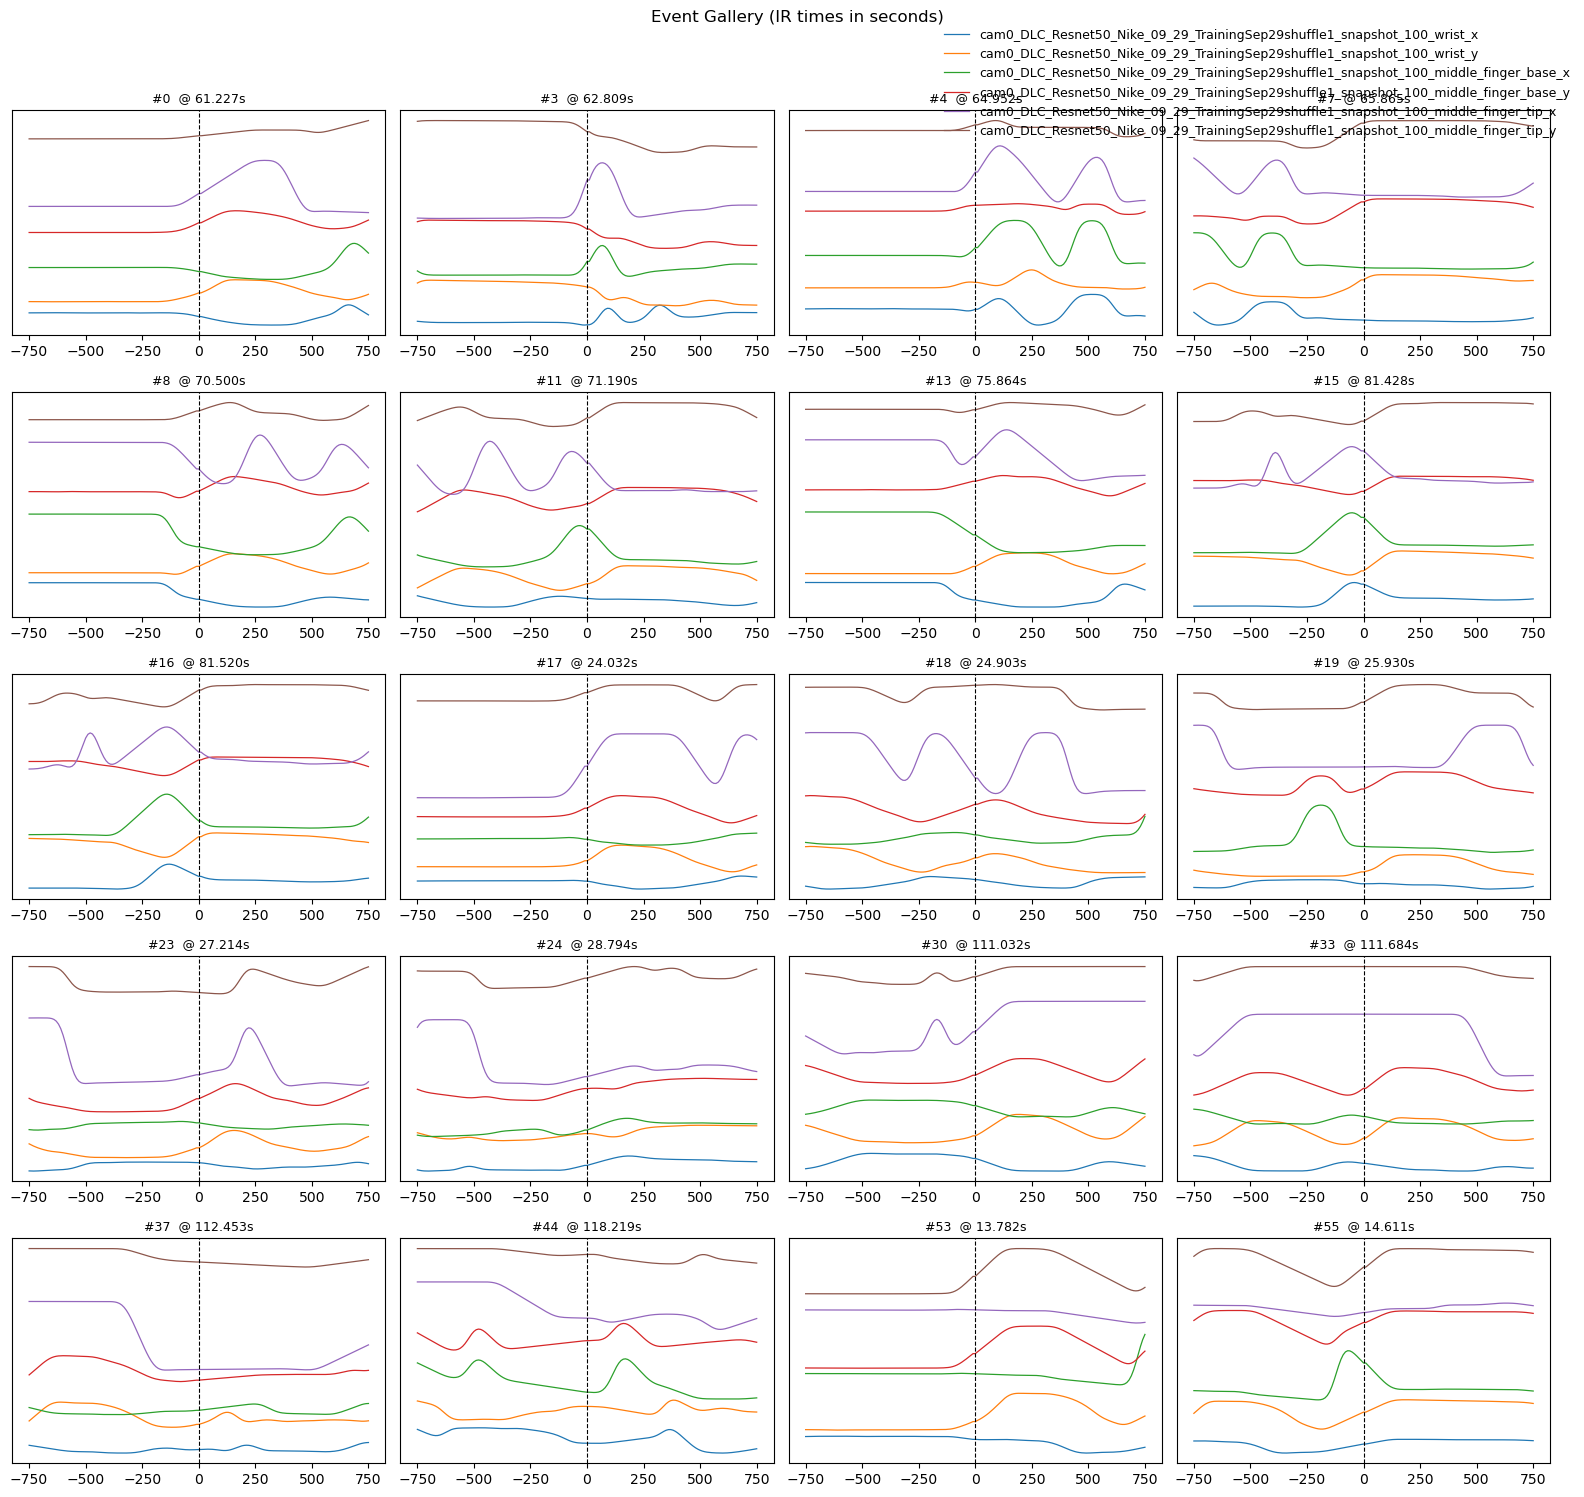

In [15]:
# Quick-start examples (edit and run):
print('There are', N, 'events and', K, 'trace columns.')
print('First few labels (if present):')
list_traces(max_show=12)

# Preview a single event:
# plot_event(6, traces=[0,1,2,3,4,5])

# Scan several events:
curated = [0, 3, 4, 7, 8, 11, 13, *range(15, 20), 23, 24, 30, 33, 37, 44, 53, 55]
plot_gallery(curated, ncols=4, traces=[0,1,2,3,4,5])

# Group stats over all or a subset:
# plot_mean_sem(indices=None, traces=[0,1])          # all events
#plot_mean_sem(indices=curated, traces=[0,1,2])   # chosen subset

# When you're ready to save your curation:
#save_curation(curated, note='Good quality pulls only')
